#
<FONT size="10pt"> <center>Projet 5 : Segmentez des clients d'un site e-commerce </center></FONT>. 

Vous êtes consultant pour **Olist**, une entreprise brésilienne qui propose une solution de vente sur les **marketplaces en ligne**.
Olist souhaite que vous fournissiez à ses équipes d'e-commerce une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une **proposition de contrat de maintenance** basée sur une analyse de la stabilité des segments au cours du temps.


<FONT size="5pt"> Les données </FONT>: 

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

<FONT size="5pt"> Votre mission </FONT>:

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.

Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire.

**Base de Données** : https://www.kaggle.com/olistbr/brazilian-ecommerce

# 1 : Librairies et Options :

In [1]:
import pandas as pd
from PIL import Image
import missingno as msno
import matplotlib.pyplot as plt
from googletrans import Translator
import time
import math
from tqdm import tqdm
import seaborn as sns
import json
from urllib.request import urlopen
import plotly.express as px
from datetime import datetime
from zoneinfo import ZoneInfo
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import re
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # Largeur écran

pd.set_option('mode.chained_assignment', None) # Pour ne pas avoir de message d'erreur quand on crée nouvelle df à partir d'une autre (app)

# 2  : Definitions pour nettoyage des fichiers sources

## 2.1 : Fichier commandes

In [2]:
def nettoyagecommandes(CSV) :
    # ouverture du fichier
    commandes = pd.read_csv(CSV)
    
    # Gardons que les commandes livrées :
    commandes = commandes[commandes['order_status'] == 'delivered']

    # Suppression de cette variable devenue inutile :
    del commandes['order_status']
    
    # Transformation Dates d'achat, d'approbation, livreur et acheteur :
    Dates = ['order_delivered_customer_date','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_estimated_delivery_date']
    for date in Dates :
        commandes[date] = pd.to_datetime(commandes[date])
        
    # Suppression des lignes sans date de livraison chez le client :
    commandes = commandes[commandes['order_delivered_customer_date'].notna()]
    
    # Extraction du mois :
    commandes['MoisCommande'] = commandes['order_purchase_timestamp'].dt.month

    # Extraction de l'année :
    commandes['AnneeCommande'] = commandes['order_purchase_timestamp'].dt.year

    # Extraction de la semaine (isocalendar not gregorian) :
    commandes['SemaineCommande'] = commandes['order_purchase_timestamp'].apply(lambda x: x.isocalendar()[1])
    
    # Création d'un delais entre commande et livraison : 
    commandes['DelaisLivraison(j)'] = commandes['order_delivered_customer_date'] - commandes['order_purchase_timestamp']
    commandes['DelaisLivraison(j)'] = commandes['DelaisLivraison(j)'].apply(lambda x : int(str(pd.Timedelta(x).round(freq = 'd')).split(' ')[0]))
    
    # Création d'une colonne retard :
    commandes['RetardLivraison(j)'] = commandes['order_delivered_customer_date'] - commandes['order_estimated_delivery_date']
    commandes['RetardLivraison(j)'] = commandes['RetardLivraison(j)'].apply(lambda x : int(str(pd.Timedelta(x).round(freq = 'd')).split(' ')[0]))
    commandes['RetardLivraison(j)'] = commandes['RetardLivraison(j)'].apply(lambda x : 0 if x < 0 else x)
    
    # Création d'une date depuis le dernier achat (Comme si on était en 2019) :
    Now = np.datetime64(datetime.now(tz=ZoneInfo("America/Sao_Paulo")) - relativedelta(years = 4))
    commandes['DelaisDernierAchat(j)'] = commandes['order_purchase_timestamp'].apply(lambda x : int(str((Now - x).round('d')).split(' ')[0]))
    
    # Suppression des variables temps:
    del commandes['order_purchase_timestamp']
    del commandes['order_approved_at']
    del commandes['order_delivered_carrier_date']
    del commandes['order_delivered_customer_date']
    del commandes['order_estimated_delivery_date']
    
    return commandes

## 2.2 : Fichier reviews

In [3]:
def nettoyagereviews(CSV) :
    # Ouverture des fichiers :
    reviews = pd.read_csv(CSV)
    
    # Transformation de la colonne message :
    reviews['review_comment_message'] = reviews['review_comment_message'].apply(lambda x : 1 if type(x) == str else 0)

    # Suppressions colonnes :
    del reviews['review_id'] # si c'est un type de réponse difficile à utiliser.
    del reviews['review_comment_title'] # presque vide.
    del reviews['review_creation_date'] # A quoi ça correspond sachant qu'on est toujours à minuit pile et que bien souvent il y a pas de messages.
    del reviews['review_answer_timestamp'] # Réponse à quoi si il y a rien et quelle réponse.
    del reviews['review_comment_message'] # Peu utile au final
    
    # Groupby sur min(), les scores ayant tendances à diminuer avec les messages des clients sur les doublons :
    reviews = reviews.groupby('order_id').min().reset_index()

    return reviews

## 2.3 : Fichier payments

In [4]:
def nettoyagepayments(CSV):
    # Ouverture du fichier :
    payments = pd.read_csv(CSV)

    # Pivot de la table pour avoir une ligne par commande :
    PI = payments.groupby('order_id')['payment_installments'].max().to_frame()
    payments = pd.pivot_table(payments, index = 'order_id', columns=['payment_type'], values='payment_value' )
    payments = pd.merge(payments, PI, left_index = True, right_index = True)
    payments.reset_index(inplace = True)
    payments = payments.fillna(0)
    
    # Suppression des colonnes :
    del payments['not_defined']
    
    # modification des noms de colonnes et cumule des deux colonnes card:
    payments['CB'] = payments['credit_card'] + payments['debit_card']
    del payments['credit_card']
    del payments['debit_card']

    payments.columns = ['order_id','Billets', 'Bons', 'NbPaiement', 'CB']

    # Suppression des colonnes Billets/Bons/NbPaiement inutile pour le moment:
    del payments['Billets']
    del payments['Bons']
    del payments['CB']
    
    return payments

## 2.4 : Fichier Produits

In [5]:
# produits achetés:
def nettoyageproduits(CSV):
    # Ouverture du fichier :
    produits = pd.read_csv(CSV)

    # Suppression colonnes :
    del produits['shipping_limit_date']
    
    # groupby pour avoir une seule ligne par commande :
    produits = produits.groupby('order_id').agg({'product_id': 'count', 'seller_id': list, 'price':'mean', 'freight_value': 'mean'}).reset_index()
    produits['seller_id'] = produits['seller_id'].apply(lambda x : ''.join(x))
    produits.head()
    
    return produits

## 2.5 : Fichier vendeurs

In [6]:
def nettoyagevendeurs(CSV) :
    # Ouverture du fichier :
    vendeurs = pd.read_csv(CSV)
    
    # suppression colonnes :
    del vendeurs['seller_zip_code_prefix']
    del vendeurs['seller_state']
    
    return vendeurs

## 2.7 : Fichier clients

In [7]:
def nettoyageclients(CSV):
    # Ouverture Fichier :
    clients = pd.read_csv(CSV)

    # Suppression colonnes :
    del clients['customer_zip_code_prefix']
    del clients['customer_state']
    
    return clients

## 2.8 : Fichier geo

In [8]:
def nettoyagegeo(CSV):
    # Ouverture du fichier :
    geo = pd.read_csv(CSV)
    
    # Un point par ville (moyenne) :
    geo = geo.groupby('geolocation_city').agg({'geolocation_lat' : 'mean','geolocation_lng' : 'mean', 'geolocation_city' : 'unique', 'geolocation_state' : 'unique'})
    
    # Colonne Lat/Long
    def GeoLoc(value):
        Lat, Long = value['geolocation_lat'], value['geolocation_lng']
        return ([Lat, Long])

    geo['Coordonnees'] = geo[['geolocation_lat','geolocation_lng']].apply(GeoLoc, axis = 1)
    
    # Modification et suppression colonnes :
    del geo['geolocation_lat']
    del geo['geolocation_lng']
    del geo['geolocation_state']

    geo['geolocation_city'] = geo['geolocation_city'].apply(lambda x : x[0])
    geo = geo.reset_index(drop = True)
    
    return geo

# 3 : Merge des fichiers

In [9]:
#Nettoyage des fichiers :
commandes = nettoyagecommandes('olist_orders_dataset.csv')
reviews = nettoyagereviews('olist_order_reviews_dataset.csv')
payments = nettoyagepayments('olist_order_payments_dataset.csv')
produits = nettoyageproduits('olist_order_items_dataset.csv')
vendeurs = nettoyagevendeurs('olist_sellers_dataset.csv')
clients = nettoyageclients('olist_customers_dataset.csv')
geo = nettoyagegeo('olist_geolocation_dataset.csv')

# Merge des fichiers :
Data = commandes.copy()
Data = pd.merge(Data, payments, how = 'inner')
Data = pd.merge(Data, produits, how = 'inner')
Data = pd.merge(Data, clients, how = 'inner')
Data = pd.merge(Data, reviews, how = 'inner')
Data = pd.merge(Data, vendeurs, how = 'inner')
Data = pd.merge(Data, geo, right_on = 'geolocation_city', left_on = 'customer_city', how = 'inner')
Data = pd.merge(Data, geo, right_on = 'geolocation_city', left_on = 'seller_city', how = 'inner')
    
Data.head(3)

C:\Users\Johan\AppData\Local\Temp\ipykernel_15428\643997254.py:38: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  Now = np.datetime64(datetime.now(tz=ZoneInfo("America/Sao_Paulo")) - relativedelta(years = 4))


,order_id,customer_id,MoisCommande,AnneeCommande,SemaineCommande,DelaisLivraison(j),RetardLivraison(j),DelaisDernierAchat(j),NbPaiement,product_id,seller_id,price,freight_value,customer_unique_id,customer_city,review_score,seller_city,geolocation_city_x,Coordonnees_x,geolocation_city_y,Coordonnees_y
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,10,2017,40,8,0,659,1,1,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,sao paulo,4,maua,sao paulo,"[-23.57086022590876, -46.63324177930123]",maua,"[-23.669993795741274, -46.4489086924047]"
1,e71fb32bec49dd4112bcbcc19126d388,f6c383cc79b182ce1550bc57504941c3,8,2017,31,6,0,720,1,1,3504c0cb71d7fa48d967e0e4c94d59d9,44.99,7.78,59b5158dcd4ab8fce908aba30ea36cc9,sao paulo,5,maua,sao paulo,"[-23.57086022590876, -46.63324177930123]",maua,"[-23.669993795741274, -46.4489086924047]"
2,03eae39a27aeab0f8c9ad5b84555a6d1,d91337c4d268a8a9f17bef015ce9af3d,8,2017,33,4,0,707,1,1,3504c0cb71d7fa48d967e0e4c94d59d9,48.90,11.73,f4f203a8ddb0c3e44212a6eaf379348e,sao paulo,5,maua,sao paulo,"[-23.57086022590876, -46.63324177930123]",maua,"[-23.669993795741274, -46.4489086924047]"


# 4 : Definition de nettoyage et nettoyage du fichier merge

In [10]:
def nettoyagedata(Data):
    
    # Suppression des ID sauf le unique ID:
    del Data['seller_id']
    del Data['customer_id']
    del Data['order_id']
    del Data['product_id']
    
    # Etude des villes (pas utile):
    del Data['customer_city']
    del Data['seller_city']
    
    # Création d'une colonne nombre de commande max :
    NBCommande = Data['customer_unique_id'].value_counts().to_frame().reset_index().rename(columns = {'customer_unique_id': 'NbCommande','index' : 'customer_unique_id'})
    Data = pd.merge(Data, NBCommande, how = 'inner')
    
    # Variables de geolocalisation :
    del Data['geolocation_city_x']
    del Data['geolocation_city_y']

    from haversine import haversine, Unit

    def harvesinedef (row):
        lieu1, lieu2 = row[0], row[1]
        return int(haversine(lieu1, lieu2))

    Data['DistanceHarvesine'] = Data[['Coordonnees_x','Coordonnees_y']].apply(harvesinedef, axis = 1)

    del Data['Coordonnees_x']
    del Data['Coordonnees_y']
    
    # Ajout d'une colonne totale:
    Data['CoutTotal'] = Data['price'] + Data['freight_value']
    
    # Float/Int:
    Transfo = ['DelaisLivraison(j)', 'RetardLivraison(j)', 'review_score', 'DistanceHarvesine']
    
    for trans in Transfo:
        Data[trans] = Data[trans].astype(int)
        
    # Transformation log:
    Variables = ['CoutTotal']

    for var in Variables :
        Data[var + '(log)'] = np.log(1 + Data[var])
    
    return Data

In [11]:
# Récupération du fichier Data aprés nettoyage :
Data = nettoyagedata(Data)
Data.head(3)

,MoisCommande,AnneeCommande,SemaineCommande,DelaisLivraison(j),RetardLivraison(j),DelaisDernierAchat(j),NbPaiement,price,freight_value,customer_unique_id,review_score,NbCommande,DistanceHarvesine,CoutTotal,CoutTotal(log)
0,10,2017,40,8,0,659,1,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,4,2,21,38.71,3.681603
1,9,2017,36,1,0,687,1,35.39,8.72,7c396fd4830fd04220f754e42b4e5bff,5,2,19,44.11,3.809104
2,8,2017,31,6,0,720,1,44.99,7.78,59b5158dcd4ab8fce908aba30ea36cc9,5,1,21,52.77,3.984716


# 5 : Analyse par zone de temps

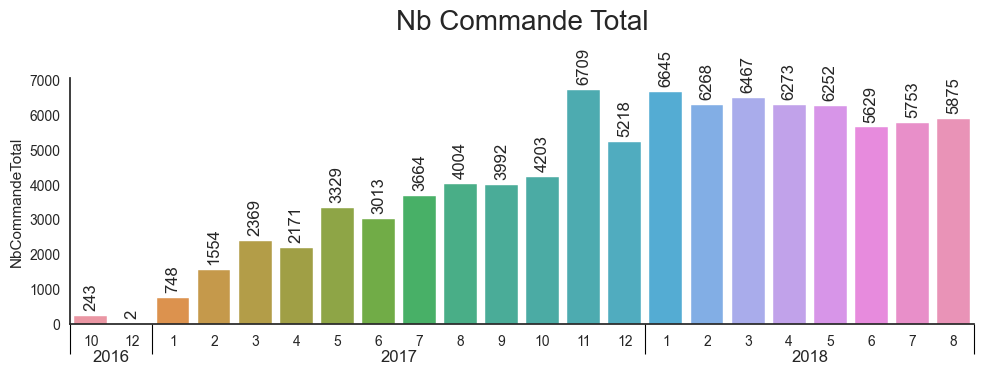

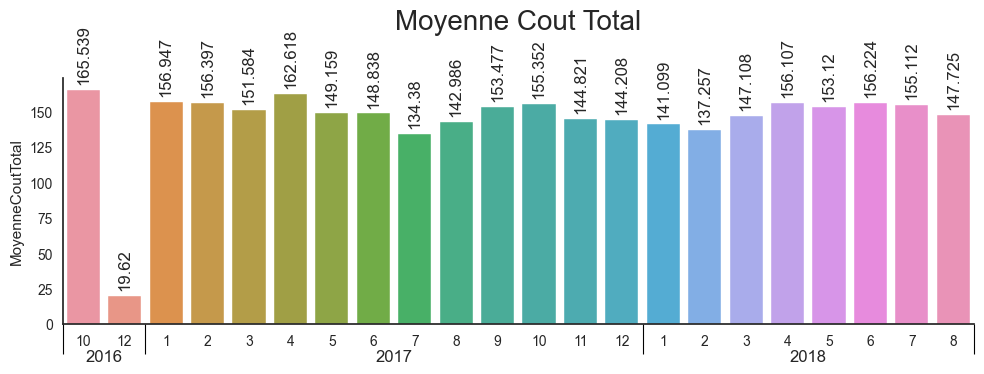

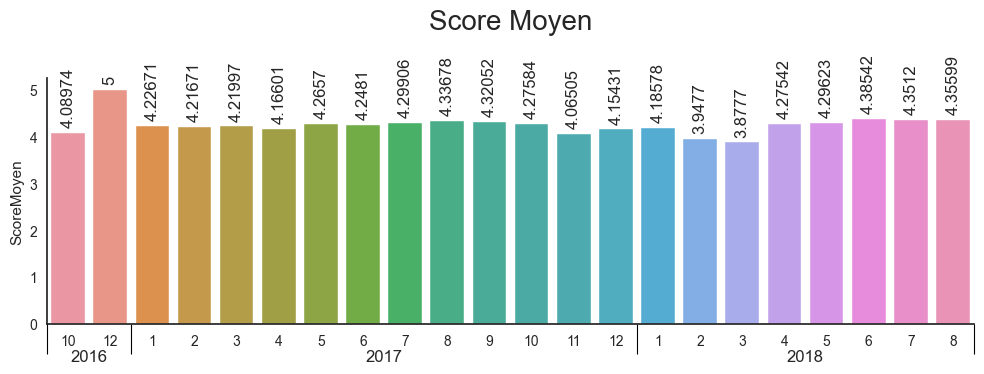

In [12]:
# Par mois :
DataMonth = Data.groupby(['AnneeCommande','MoisCommande']).agg({'DelaisLivraison(j)' : 'mean', 'RetardLivraison(j)' : 'mean', 'DelaisDernierAchat(j)' : 'mean',
       'NbPaiement' : 'mean','price' : 'mean', 'freight_value': 'mean', 'review_score' : 'mean',
       'NbCommande' : 'sum', 'DistanceHarvesine' : 'mean', 'CoutTotal' : 'mean', 'CoutTotal(log)' : 'mean'})
DataMonth = DataMonth.reset_index()
DataMonth.columns = ['AnneeCommande', 'MoisCommande', 'DelaisLivraison(j)', 'RetardLivraison(j)', 'MoyenneDelaisDernierAchat(j)', 'NbPaiementMoyen', 'CoutCommandeMoyen', 'CoutTransportMoyen', 'ScoreMoyen', 'NbCommandeTotal', 'DistanceOiseau', 'MoyenneCoutTotal', 'CoutTotal(log)']

DataMonth = DataMonth[['AnneeCommande', 'MoisCommande', 'MoyenneDelaisDernierAchat(j)', 'NbCommandeTotal', 'MoyenneCoutTotal','ScoreMoyen']]
DataMonth['yearmonth'] = (DataMonth['AnneeCommande'].astype(str) + DataMonth['MoisCommande'].astype(str)).astype(int)

Variables = ['NbCommandeTotal', 'MoyenneCoutTotal','ScoreMoyen']

for var in Variables :
    sns.set_style("white")
    sns.set_color_codes("pastel")
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(x = DataMonth.index , y = DataMonth[var], ax=ax)
    sns.despine()
    plt.title(' '.join(re.findall('[A-Z][^A-Z]*', var)), size = 20, pad=35)
    ax.set_xticklabels(DataMonth['MoisCommande'])
    ax.set_xlabel('')
    ax.bar_label(ax.containers[0], padding=4, rotation = 90)

    yearmonth_labels = list(DataMonth['yearmonth'].values)
    for i, j in zip(yearmonth_labels, range(len(yearmonth_labels))) :
            if len(str(i)) == 5:
                i = str(i)
                i = i[:-1]+'0'+i[-1:]
                yearmonth_labels[j] = int(i)

    # calculate the positions of the borders between the years
    pos = []
    years = []
    prev = None
    for i, ym in enumerate(yearmonth_labels):
        if ym // 100 != prev:
            pos.append(i)
            prev = ym // 100
            years.append(prev)
    pos.append(len(yearmonth_labels))
    pos = np.array(pos) - 0.5
    # vertical lines to separate the years
    ax.vlines(pos, 0, -0.12, color='black', lw=0.8, clip_on=False, transform=ax.get_xaxis_transform())
    # years at the center of their range
    for year, pos0, pos1 in zip(years, pos[:-1], pos[1:]):
        ax.text((pos0 + pos1) / 2, -0.15, year, ha='center', clip_on=False, transform=ax.get_xaxis_transform())

    ax.set_xlim(pos[0], pos[-1])
    ax.set_ylim(ymin=0)
    plt.tight_layout()
    plt.show()

- **On observe pas de différence flagrande au mois par mois.**

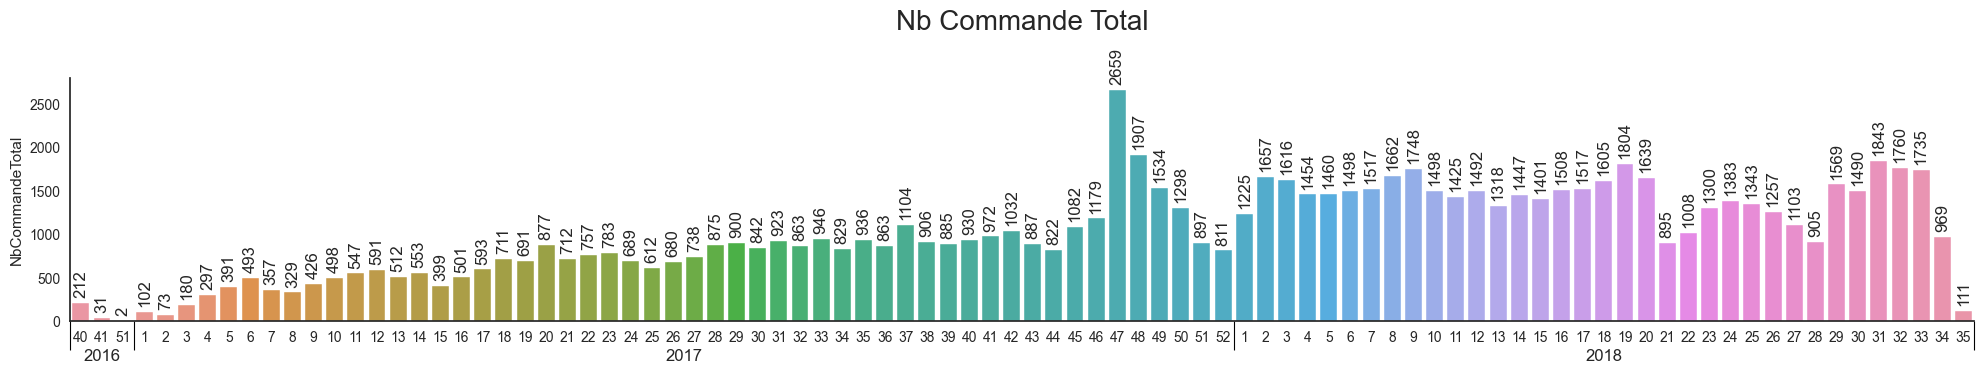

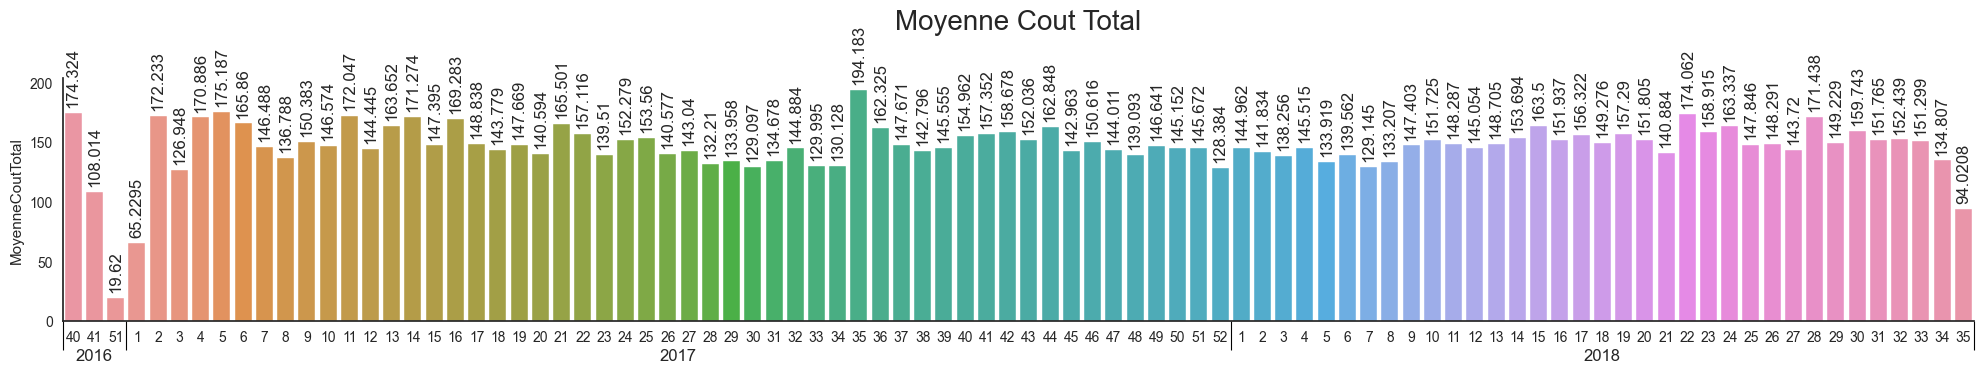

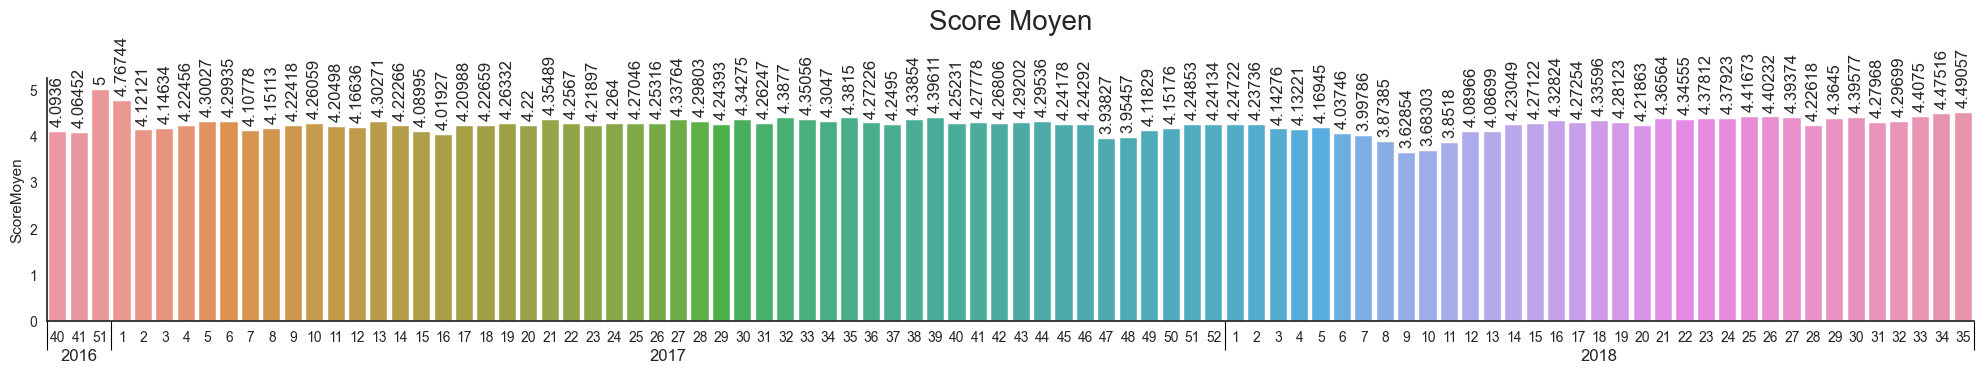

In [13]:
# Par semaine :
DataWeek = Data.groupby(['AnneeCommande','SemaineCommande']).agg({'DelaisLivraison(j)' : 'mean', 'RetardLivraison(j)' : 'mean', 'DelaisDernierAchat(j)' : 'mean',
       'NbPaiement' : 'mean','price' : 'mean', 'freight_value': 'mean', 'review_score' : 'mean',
       'NbCommande' : 'sum', 'DistanceHarvesine' : 'mean', 'CoutTotal' : 'mean', 'CoutTotal(log)' : 'mean'})
DataWeek = DataWeek.reset_index()
DataWeek.columns = ['AnneeCommande', 'SemaineCommande', 'DelaisLivraison(j)', 'RetardLivraison(j)', 'MoyenneDelaisDernierAchat(j)', 'NbPaiementMoyen', 'CoutCommandeMoyen', 'CoutTransportMoyen', 'ScoreMoyen', 'NbCommandeTotal', 'DistanceOiseau', 'MoyenneCoutTotal', 'CoutTotal(log)']

DataWeek = DataWeek[['AnneeCommande', 'SemaineCommande', 'MoyenneDelaisDernierAchat(j)', 'NbCommandeTotal', 'MoyenneCoutTotal','ScoreMoyen']]
DataWeek['yearWeek'] = (DataWeek['AnneeCommande'].astype(str) + DataWeek['SemaineCommande'].astype(str)).astype(int)

Variables = ['NbCommandeTotal', 'MoyenneCoutTotal','ScoreMoyen']

for var in Variables :
    sns.set_style("white")
    sns.set_color_codes("pastel")
    fig, ax = plt.subplots(figsize=(20, 4))
    sns.barplot(x = DataWeek.index , y = DataWeek[var], ax=ax)
    sns.despine()
    plt.title(' '.join(re.findall('[A-Z][^A-Z]*', var)), size = 20, pad=35)
    ax.set_xticklabels(DataWeek['SemaineCommande'])
    ax.set_xlabel('')
    ax.bar_label(ax.containers[0], padding=4, rotation = 90)

    yearWeek_labels = list(DataWeek['yearWeek'].values)
    for i, j in zip(yearWeek_labels, range(len(yearWeek_labels))) :
            if len(str(i)) == 5:
                i = str(i)
                i = i[:-1]+'0'+i[-1:]
                yearWeek_labels[j] = int(i)

    # calculate the positions of the borders between the years
    pos = []
    years = []
    prev = None
    for i, ym in enumerate(yearWeek_labels):
        if ym // 100 != prev:
            pos.append(i)
            prev = ym // 100
            years.append(prev)
    pos.append(len(yearWeek_labels))
    pos = np.array(pos) - 0.5
    # vertical lines to separate the years
    ax.vlines(pos, 0, -0.12, color='black', lw=0.8, clip_on=False, transform=ax.get_xaxis_transform())
    # years at the center of their range
    for year, pos0, pos1 in zip(years, pos[:-1], pos[1:]):
        ax.text((pos0 + pos1) / 2, -0.16, year, ha='center', clip_on=False, transform=ax.get_xaxis_transform())

    ax.set_xlim(pos[0], pos[-1])
    ax.set_ylim(ymin=0)
    plt.tight_layout()
    plt.show()

- **Etude par semaine montre les mêmes choses pour les scores et le delais depuis la dernière commande que l'étude par mois.**
- **Pour les deux autres variables on a un pic entre mis novembre et mis décembre.**

- **Peut être est il intéressant de n'étudier que la dernière année mois à mois.**

# 6 : Etude des KMeans par semaine et par mois

## 6.1 : Définitions des KMeans et autres

In [14]:
def addzero(value) :
    if len(str(value)) == 5:
        i = str(value)
        i = i[:-1]+'0'+i[-1:]
        return int(i)
    else :
        return value

In [15]:
def ExtractionDonnees(Periode, Data) :

    try :
        DataKM = Data[Data['YearMonth'] <= Periode]
    except :
        DataKM = Data[Data['YearWeek'] <= Periode]
    
    DataKM = DataKM.groupby('customer_unique_id').agg({'DelaisLivraison(j)' : 'mean', 'RetardLivraison(j)' : 'mean', 'DelaisDernierAchat(j)' : 'min',
       'NbPaiement' : 'mean','price' : 'mean', 'freight_value': 'mean', 'review_score' : 'mean', 'NbCommande' : 'max','DistanceHarvesine' : 'mean', 'CoutTotal(log)' : 'mean'})
    DataKM.reset_index(inplace = True)

    # Noms des colonnes :
    DataKM.columns = ['N°Client','DelaisLivraison(j)', 'RetardLivraison(j)', 'DelaisDernierAchat(j)', 'NbPaiementMoyen', 'CoutCommandeMoyen', 'CoutTransportMoyen', 'ScoreMoyen', 'NbCommandeTotal', 'DistanceOiseau', 'CoutTotal(log)']
    return DataKM

In [16]:
def dicocentroides(centroides):
    values = []
    for i in centroides[:, :1]:
        values.append(float(i))
    values
    newvalues = values.copy()
    newvalues.sort()
    
    DicoClust = {}
    for i in range(len(values)):
        value = values[i]
        DicoClust[i] = newvalues.index(value)
    return DicoClust

def replaceclusters(values, DicoClust):
    
    for i,j in zip(values, range(len(values))) :
        for key, value in DicoClust.items():
            if i == key :
                values[j] = value
       
    return values

In [17]:
def MinMaxScaler(df):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler().fit(df)
    Scores = pd.DataFrame(scaler.transform(df))
    Scores.columns = df.columns
    X = Scores
    return X

In [18]:
def KMeansARI(Periode1, Periode2) :

    # Données :
    Periode1 = Periode1[['DelaisDernierAchat(j)', 'NbCommandeTotal', 'CoutTotal(log)', 'ScoreMoyen']]
    Periode2 = Periode2[['DelaisDernierAchat(j)', 'NbCommandeTotal', 'CoutTotal(log)', 'ScoreMoyen']]
    
    # MinMaxScaler:
    Periode1 = MinMaxScaler(Periode1)
    Periode2 = MinMaxScaler(Periode2)
    
    # Complet sur ancienne periode (la 1) : 
        # Scale des données :
    scaler1 = StandardScaler().fit(Periode1)
    Scores = pd.DataFrame(scaler1.transform(Periode1))
    X_scaled1 = Scores
        # KMeans :
    model = KMeans(n_clusters = 5, n_init = 10)
    model1 = model.fit(X_scaled1)

    # Complet sur nouvelle periode (la 2) avec fit sur nouvelle periode: 
        # Scale des données :
    scaler2 = StandardScaler().fit(Periode2)
    Scores = pd.DataFrame(scaler2.transform(Periode2))
    X_scaled2 = Scores
        # KMeans :
    model2 = model.fit(X_scaled2)
    CC2 = dicocentroides(model2.cluster_centers_)
    clusters2new = model2.predict(X_scaled2)
    clusters2new = replaceclusters(clusters2new, CC2)

    # Complet sur nouvelle periode (la 2) avec fit sur ancienne periode: 
        # Scale des données :
    Scores = pd.DataFrame(scaler1.transform(Periode2))
    X_scaled3 = Scores
        # KMeans :
    clusters2old = model1.predict(X_scaled3)
    clusters2old = replaceclusters(clusters2old, CC2)
    
    # ARI :
    ARI = adjusted_rand_score(clusters2old, clusters2new)
    
    # Accuracy :
    ACC = accuracy_score(clusters2old, clusters2new)
    
    Periode2['KMeansnew'] = clusters2new
    Periode2['KMeansold'] = clusters2old
    
    return ARI, ACC, Periode2

## 6.2 : Etude par Semaine

In [19]:
DataKsemaines = Data.copy()

# Création d'une colonne pour le sclice :
DataKsemaines['YearWeek'] = (DataKsemaines['AnneeCommande'].astype(str) + DataKsemaines['SemaineCommande'].astype(str)).astype(int)   
DataKsemaines['YearWeek'] = DataKsemaines['YearWeek'].apply(addzero)

In [20]:
# Réordonner les semaines :
Semaines = list(DataKsemaines['YearWeek'].unique())
Semaines.sort(reverse = True)

# Periode la plus récente;
Periode2 = ExtractionDonnees(201835, DataKsemaines)
ARI = []
Accuracy = []

# Récupération des données puis de l'ARI :
for i in range(0,30) :
    try :
        Periode1 = ExtractionDonnees(Semaines[i], DataKsemaines)
        Resultats = KMeansARI(Periode1, Periode2)
        print("Pour la période jusqu'à la semaine 35 de l'année 2018 vs {} semaine(s) plus tôt, le ARI est de : {} et l'Accuracy Score est de : {}.".format(i, round(Resultats[0],3), round(Resultats[1],3)))
        ARI.append(round(Resultats[0],3))
        Accuracy.append(round(Resultats[1],3))
    except : # Vu qu'il va manque une periode 2 pour la dernière colonne.
        pass

Pour la période jusqu'à la semaine 35 de l'année 2018 vs 0 semaine(s) plus tôt, le ARI est de : 1.0 et l'Accuracy Score est de : 1.0.
Pour la période jusqu'à la semaine 35 de l'année 2018 vs 1 semaine(s) plus tôt, le ARI est de : 0.993 et l'Accuracy Score est de : 0.997.
Pour la période jusqu'à la semaine 35 de l'année 2018 vs 2 semaine(s) plus tôt, le ARI est de : 0.962 et l'Accuracy Score est de : 0.987.
Pour la période jusqu'à la semaine 35 de l'année 2018 vs 3 semaine(s) plus tôt, le ARI est de : 0.962 et l'Accuracy Score est de : 0.987.
Pour la période jusqu'à la semaine 35 de l'année 2018 vs 4 semaine(s) plus tôt, le ARI est de : 0.961 et l'Accuracy Score est de : 0.986.
Pour la période jusqu'à la semaine 35 de l'année 2018 vs 5 semaine(s) plus tôt, le ARI est de : 0.961 et l'Accuracy Score est de : 0.987.
Pour la période jusqu'à la semaine 35 de l'année 2018 vs 6 semaine(s) plus tôt, le ARI est de : 0.958 et l'Accuracy Score est de : 0.985.
Pour la période jusqu'à la semaine 35 

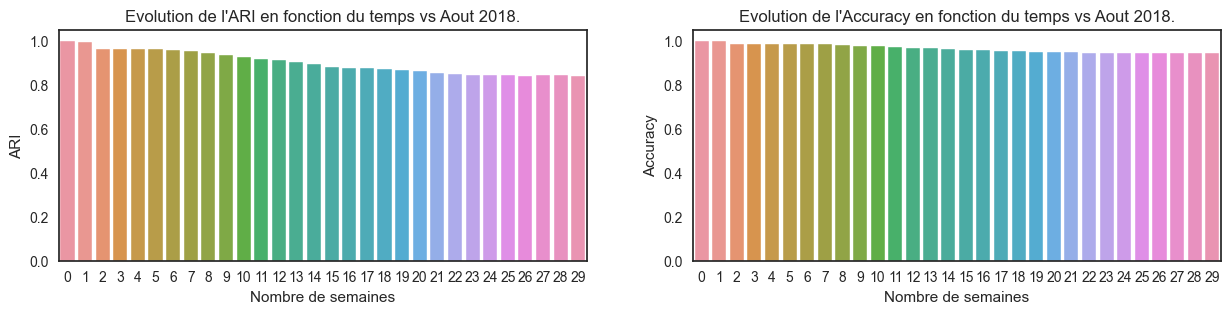

In [21]:
# Résultats graphiques :
df = pd.DataFrame(list(zip(ARI,Accuracy)), columns = ['ARI','Accuracy'])
zones = [121,122]

plt.subplots(1,2,figsize = (15,3))
for col, z in zip(df.columns, zones) :
    plt.subplot(z)
    sns.barplot(x = df.index, y = df[col])
    plt.title("Evolution de l'{} en fonction du temps vs Aout 2018.".format(col))
    plt.xlabel('Nombre de semaines')
plt.show()

- **L'étude par semaine n'est pas concluante.**

## 6.3 : Etude par Mois

In [22]:
DataKmois = Data.copy()

# Création d'une colonne pour le sclice :
DataKmois['YearMonth'] = (DataKmois['AnneeCommande'].astype(str) + DataKmois['MoisCommande'].astype(str)).astype(int)   
DataKmois['YearMonth'] = DataKmois['YearMonth'].apply(addzero)

In [23]:
# Réordonner les mois :
Month = list(DataKmois['YearMonth'].unique())
Month.sort(reverse = True)

# Periode la plus récente :
Periode2 = ExtractionDonnees(201808, DataKmois)
ARI = []
Accuracy = []

# Récupération des données puis de l'ARI :
for i in range(len(Month)) :
    try :
        Periode1 = ExtractionDonnees(Month[i], DataKmois)
        Resultats = KMeansARI(Periode1, Periode2)
        print("Pour la période jusqu'au mois d'Août 2018 vs {} mois plus tôt, le ARI est de : {} et l'Accuracy Score est de : {}.".format(i, round(Resultats[0],3), round(Resultats[1],3)))
        ARI.append(round(Resultats[0],3))
        Accuracy.append(round(Resultats[1],3))
    except : # Vu qu'il va manque une periode 2 pour le dernière colonne.
        pass

Pour la période jusqu'au mois d'Août 2018 vs 0 mois plus tôt, le ARI est de : 1.0 et l'Accuracy Score est de : 1.0.
Pour la période jusqu'au mois d'Août 2018 vs 1 mois plus tôt, le ARI est de : 0.96 et l'Accuracy Score est de : 0.986.
Pour la période jusqu'au mois d'Août 2018 vs 2 mois plus tôt, le ARI est de : 0.931 et l'Accuracy Score est de : 0.976.
Pour la période jusqu'au mois d'Août 2018 vs 3 mois plus tôt, le ARI est de : 0.9 et l'Accuracy Score est de : 0.964.
Pour la période jusqu'au mois d'Août 2018 vs 4 mois plus tôt, le ARI est de : 0.872 et l'Accuracy Score est de : 0.954.
Pour la période jusqu'au mois d'Août 2018 vs 5 mois plus tôt, le ARI est de : 0.85 et l'Accuracy Score est de : 0.945.
Pour la période jusqu'au mois d'Août 2018 vs 6 mois plus tôt, le ARI est de : 0.841 et l'Accuracy Score est de : 0.943.
Pour la période jusqu'au mois d'Août 2018 vs 7 mois plus tôt, le ARI est de : 0.835 et l'Accuracy Score est de : 0.941.
Pour la période jusqu'au mois d'Août 2018 vs 8 m

- **L'étude par mois est plus pertinante, il faut donc entre 11 et 12 mois pour que l'ARI passe en dessous de 0.8, l'accuracy lui reste toujours trés bon.**

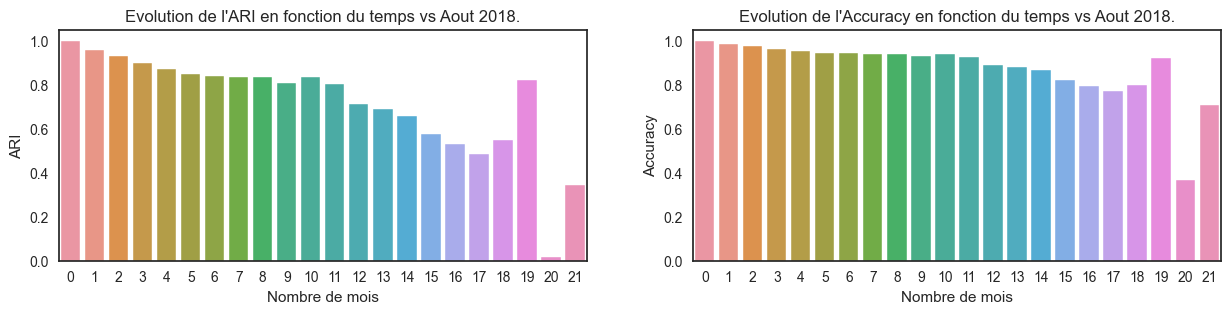

In [24]:
# Résultats graphiques :
df = pd.DataFrame(list(zip(ARI,Accuracy)), columns = ['ARI','Accuracy'])
zones = [121,122]

plt.subplots(1,2,figsize = (15,3))
for col, z in zip(df.columns, zones) :
    plt.subplot(z)
    sns.barplot(x = df.index, y = df[col])
    plt.title("Evolution de l'{} en fonction du temps vs Aout 2018.".format(col))
    plt.xlabel('Nombre de mois')
plt.show()

## 6.4 : Etude par Trismestre

In [25]:
# Récupération des données puis de l'ARI :
ARI = []
Accuracy = []
DFs = []
for i in range(len(Month)) :
    if i % 3 == 0 and i != 0 :
        try :
            Periode1 = ExtractionDonnees(Month[i], DataKmois)
            Resultats = KMeansARI(Periode1, Periode2)
            locals()['DF'+ str(int(i/3))] = KMeansARI(Periode1, Periode2)[2]
            DFs.append('DF'+ str(int(i/3)))
            print("Pour la période jusqu'au mois d'Août 2018 vs {} trimestre plus tôt, le ARI est de : {} et l'Accuracy Score est de : {}.".format(int(i/3), round(Resultats[0],3), round(Resultats[1],3)))
            ARI.append(round(Resultats[0],3))
            Accuracy.append(round(Resultats[1],3))
        except : # Vu qu'il va manque une periode 2 pour le dernière colonne.
            pass

Pour la période jusqu'au mois d'Août 2018 vs 1 trimestre plus tôt, le ARI est de : 0.9 et l'Accuracy Score est de : 0.964.
Pour la période jusqu'au mois d'Août 2018 vs 2 trimestre plus tôt, le ARI est de : 0.841 et l'Accuracy Score est de : 0.943.
Pour la période jusqu'au mois d'Août 2018 vs 3 trimestre plus tôt, le ARI est de : 0.806 et l'Accuracy Score est de : 0.929.
Pour la période jusqu'au mois d'Août 2018 vs 4 trimestre plus tôt, le ARI est de : 0.714 et l'Accuracy Score est de : 0.891.
Pour la période jusqu'au mois d'Août 2018 vs 5 trimestre plus tôt, le ARI est de : 0.574 et l'Accuracy Score est de : 0.82.
Pour la période jusqu'au mois d'Août 2018 vs 6 trimestre plus tôt, le ARI est de : 0.55 et l'Accuracy Score est de : 0.801.
Pour la période jusqu'au mois d'Août 2018 vs 7 trimestre plus tôt, le ARI est de : 0.339 et l'Accuracy Score est de : 0.707.


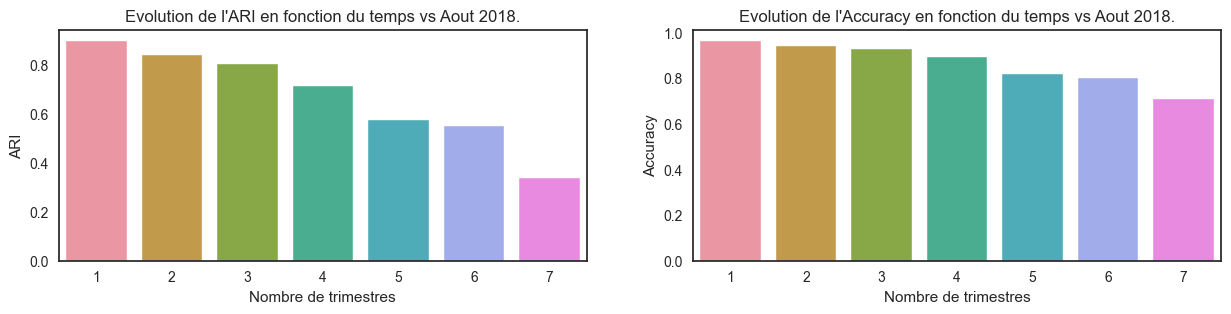

In [26]:
# Résultats graphiques :
df = pd.DataFrame(list(zip(ARI,Accuracy)), columns = ['ARI','Accuracy'])
Trimestres = [1,2,3,4,5,6,7]
zones = [121,122]

plt.subplots(1,2,figsize = (15,3))
for col, z in zip(df.columns, zones) :
    plt.subplot(z)
    sns.barplot(x = Trimestres, y = df[col])
    plt.title("Evolution de l'{} en fonction du temps vs Aout 2018.".format(col))
    plt.xlabel('Nombre de trimestres')
plt.show()

# 7 : Analyse du nombre de bon clients avec cette méthode (par trimestres) :

In [27]:
DFs

['DF1', 'DF2', 'DF3', 'DF4', 'DF5', 'DF6', 'DF7']

In [28]:
New = DF1['KMeansnew'].value_counts()
Old1 = DF1['KMeansold'].value_counts()
Old2 = DF2['KMeansold'].value_counts()
Old3 = DF3['KMeansold'].value_counts()
Old4 = DF4['KMeansold'].value_counts()
Old5 = DF5['KMeansold'].value_counts()
Old6 = DF6['KMeansold'].value_counts()
Old7 = DF7['KMeansold'].value_counts()

Analyse = pd.merge(New, Old1, right_index = True, left_index = True)
Analyse = pd.merge(Analyse, Old2, right_index = True, left_index = True)
Analyse = pd.merge(Analyse, Old3, right_index = True, left_index = True)
Analyse = pd.merge(Analyse, Old4, right_index = True, left_index = True)
Analyse = pd.merge(Analyse, Old5, right_index = True, left_index = True)
Analyse = pd.merge(Analyse, Old6, right_index = True, left_index = True)
Analyse = pd.merge(Analyse, Old7, right_index = True, left_index = True)

Analyse.columns = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
Analyse

C:\Users\Johan\AppData\Local\Temp\ipykernel_15428\788225176.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'KMeansold_x'} in the result is deprecated and will raise a MergeError in a future version.
  Analyse = pd.merge(Analyse, Old4, right_index = True, left_index = True)
C:\Users\Johan\AppData\Local\Temp\ipykernel_15428\788225176.py:15: FutureWarning: Passing 'suffixes' which cause duplicate columns {'KMeansold_x'} in the result is deprecated and will raise a MergeError in a future version.
  Analyse = pd.merge(Analyse, Old6, right_index = True, left_index = True)


,T0,T1,T2,T3,T4,T5,T6,T7
0,27118,25133,23680,22896,19578,18344,14984,49900
4,21360,23309,24826,25487,25835,31210,30499,11225
1,20726,21213,20898,20179,22614,20962,24869,11591
3,11391,10940,11191,12033,12568,12160,12328,9991
2,2116,2116,2116,2116,2116,35,31,4


In [29]:
for col in Analyse.columns[1:]:
    Analyse[col] = (round(Analyse['T0'] / Analyse[col]*100)).astype(int)

Analyse['T0'] = 100
Analyse = Analyse.reset_index()

DicoGroupes = {'0' : 'Clients les plus récents' , '1' : 'Clients les plus dépensiers', '2' : 'Clients multicommandes', '3' : 'Clients mécontents', '4' : 'Clients les plus anciens'}
def NameGroupe(values):
    for key, value in DicoGroupes.items():
        if str(values) == key:
            return value
Analyse['index'] = Analyse['index'].apply(NameGroupe)
Analyse = Analyse.set_index('index')
Analyse

,T0,T1,T2,T3,T4,T5,T6,T7
index,,,,,,,,
Clients les plus récents,100,108,115,118,139,148,181,54
Clients les plus anciens,100,92,86,84,83,68,70,190
Clients les plus dépensiers,100,98,99,103,92,99,83,179
Clients mécontents,100,104,102,95,91,94,92,114
Clients multicommandes,100,100,100,100,100,6046,6826,52900


C:\Users\Johan\AppData\Local\Temp\ipykernel_15428\2067429704.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


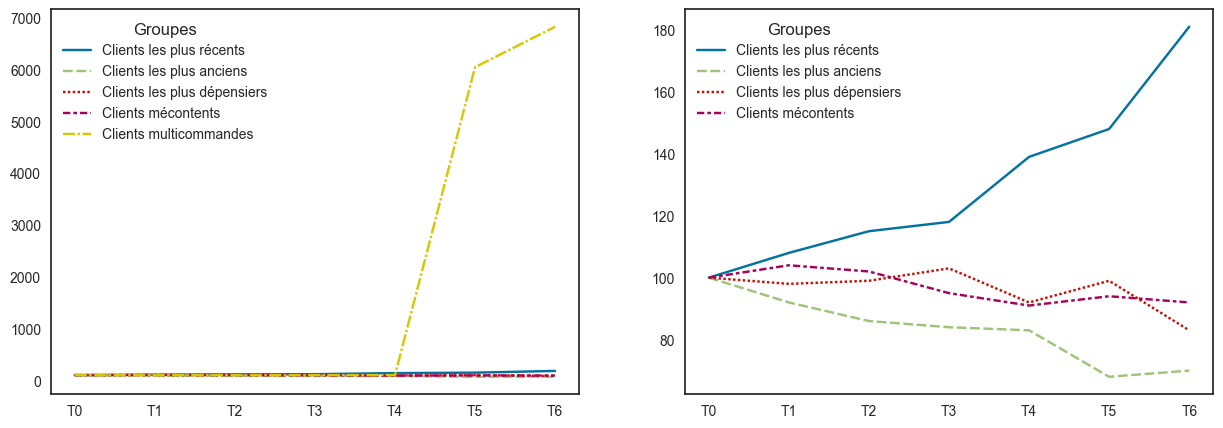

In [30]:
# Analyse graphique :
plt.subplots(figsize = (15,5))
plt.subplot(121)
sns.lineplot(Analyse.iloc[:,:-1].T)
plt.legend(title = "Groupes")

plt.subplot(122)
Analyse2 = Analyse.iloc[:-1,:-1].T
sns.lineplot(Analyse2)
plt.legend(title = "Groupes")
plt.show()